# $z < 0.4$

In [238]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner
import scipy.stats as stats

import sys
sys.path.append("../")
from pyACC.cosmology import Dc_w0waCDM

### Hubble Function

In [239]:
H0=68
def hubble_function(z,Omega_m,Omega_r,w0,wa,H0):
    return H0*np.sqrt(Omega_m*(1+z)**3+Omega_r*(1+z)**4+(1-Omega_m-Omega_r)*(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z)))

### File

In [240]:
file_path = 'lcparam_full_long.txt'

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

### Distance Modulus

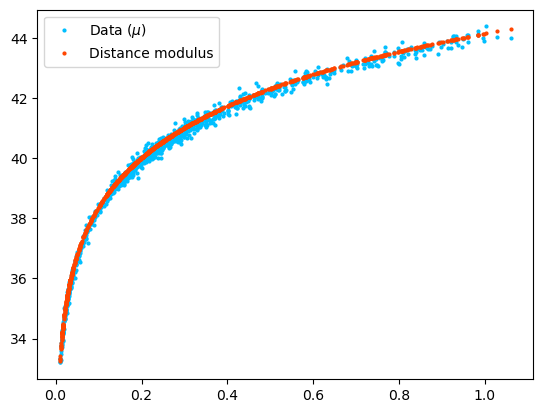

In [241]:
def get_mu(z,H0,Omega_m,Omega_r,w0,wa):
    comoving_distance=[]
    distance_modulus=[]

    for i in range(len(z)):
        comoving_distance.append(Dc_w0waCDM(hubble_function,z[i],Omega_m,Omega_r,w0,wa,H0))
        #print(comoving_distance[i])
        if comoving_distance[i]<=0:
            print(f"Invalid distance value: {comoving_distance[i]} for index {i} with redshift {z[i]}")
        distance_modulus.append(5*np.log10(comoving_distance[i]*(1+z[i]))+25)
        #print(distance_modulus[i])
    '''
    for i in range(len(z)):
        # Compute comoving distance
        dc = Dc_w0waCDM(hubble_function, z[i], Omega_m, Omega_r, w0, wa, H0)
        comoving_distance.append(dc)

        # Calculate distance * (1 + z)
        distance = dc * (1 + z[i])
        if distance <= 0:
            print(f"Error at index {i}: Invalid distance value {distance} for comoving_distance {dc} and redshift {z[i]}")
            sys.exit("Stopping execution due to invalid distance value.")

        # Compute distance modulus
        modulus = 5 * np.log10(distance) + 25
        distance_modulus.append(modulus)
    '''
    return np.array(distance_modulus)

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data,get_mu(z_data,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

Isolating $z<0.4$

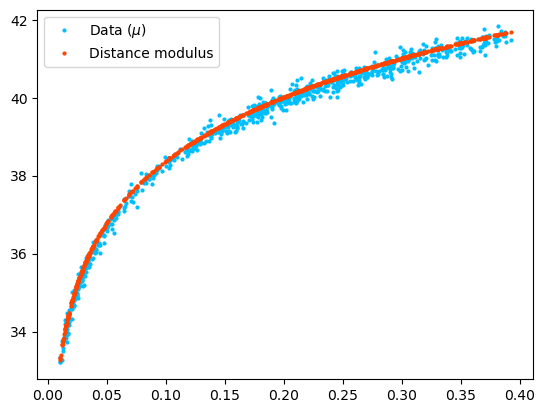

In [242]:
z_data_low=[]
mu_data_low=[]
dmb_low=[]
for i in range(len(z_data)):
    if z_data[i]<0.4:
        z_data_low.append(z_data[i])
        mu_data_low.append(mu_data[i])
        dmb_low.append(dmb[i])

z_data_low=np.array(z_data_low)
mu_data_low=np.array(mu_data_low)
dmb_low=np.array(dmb_low)

Sigma_low = np.diag(dmb_low**2)
Sigma_inv_low = np.linalg.inv(Sigma_low)

plt.plot(z_data_low,mu_data_low,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data_low,get_mu(z_data_low,68,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

### Prior

In [243]:
def log_prior(params):
    Omega_m, Omega_r, w0, wa = params
    if 0 < Omega_m < 0.7 and 0 <= Omega_r < 0.3 and -2 < w0 < 0 and -3 < wa < 2:
        return 0
    return -np.inf

### Likelihood

In [244]:
def log_likelihood(params,z,d,cov_inv):
    Omega_m,Omega_r,w0,wa=params
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    if Omega_r<0:
        #print(f"Omega_r out of bounds: {Omega_r}")
        return -np.inf
    mu=get_mu(z,H0,Omega_m,Omega_r,w0,wa)
    diff=d-mu
    #return -0.5 * diff @ cov_inv @ diff
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2
    '''
    if np.any(np.isnan(params)):
        print(f"NaN value found in params: {params}")
        return -np.inf
    if len(z)==len(z_data):
        return term1+term2
    else:
        return term1
    '''

### Posterior

In [245]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

### $\chi ^2$

In [246]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

## Parameter Optimization

In [247]:
initial_guess = [0.319, 0, -1, 0]

result = minimize(chi, initial_guess, args=(z_data_low, mu_data_low, Sigma_inv_low), method='Powell')
best_fit_params = result.x

mu_model_best = get_mu(z_data_low, H0, *best_fit_params)

/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2578: RuntimeWarning: invalid value encountered in scalar subtract
  p = (x - v) * tmp2 - (x - w) * tmp1


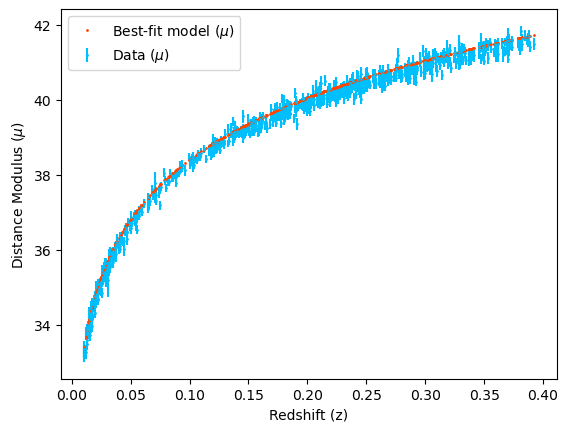

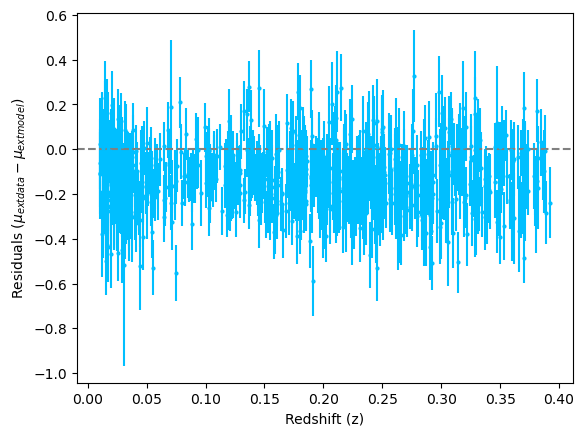

--------------------------------------
Best-fit parameters:
Omega_m: 0.24638836606277845
Omega_r: 0.00186441896105396
w0: -1.1824693098775891
wa: 1.9999852351157081
--------------------------------------
Chi-square: 778.7351868066561
Degrees of freedom: 762
Reduced chi-square: 1.0219621874103098
--------------------------------------


In [248]:
plt.errorbar(z_data_low, mu_data_low, yerr=dmb_low, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data_low, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data_low - mu_model_best
plt.errorbar(z_data_low, residuals, yerr=dmb_low, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("Omega_m:", best_fit_params[0])
print("Omega_r:", best_fit_params[1])
print("w0:", best_fit_params[2])
print("wa:", best_fit_params[3])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data_low, mu_data_low, Sigma_inv_low)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data_low) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data_low) - len(best_fit_params)))
print("--------------------------------------")

## MCMC

In [249]:
# Initialize the MCMC sampler
initial = np.array([0.319, 0, -1, 0])
ndim = len(initial)
nwalkers = 50

std_Om0 = 1e-2
std_Omr = 1e-7
std_w0_wa = 1e-1

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_Omr * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)

#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data_low, mu_data_low, Sigma_inv_low))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data_low, mu_data_low, Sigma_inv_low))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data_low, mu_data_low, Sigma_inv_low))

-398.9523994287225
-inf
-397.47383567733874
-396.9817943888593
-inf
-inf
-inf
-inf
-393.6829495137536
-390.90983117900987
-399.9018722225935
-inf
-inf
-391.9936067629653
-inf
-inf
-390.63746548640745
-inf
-401.7354950249688
-399.716002803047
-391.01146205972844
-393.6031171250875
-393.23562449479255
-inf
-inf
-401.9914220167286
-391.1244839764107
-399.23189304508537
-392.1753641648939
-395.574436287278
-inf
-393.85460723666574
-inf
-390.5011533577419
-inf
-390.579636568611
-inf
-391.4008285625731
-inf
-inf
-393.3759286743085
-395.41793147812587
-inf
-inf
-inf
-inf
-391.89206635989507
-393.7866714570013
-390.6462331774356
-inf
-398.9523994287225
-inf
-397.47383567733874
-396.9817943888593
-inf
-inf
-inf
-inf
-393.6829495137536
-390.90983117900987
-399.9018722225935
-inf
-inf
-391.9936067629653
-inf
-inf
-390.63746548640745
-inf
-401.7354950249688
-399.716002803047
-391.01146205972844
-393.6031171250875
-393.23562449479255
-inf
-inf
-401.9914220167286
-391.1244839764107
-399.231893045085

In [250]:
# Run the MCMC sampler
nsteps = 500
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100,thin=10,flat=True)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [18:16<00:00,  2.19s/it]


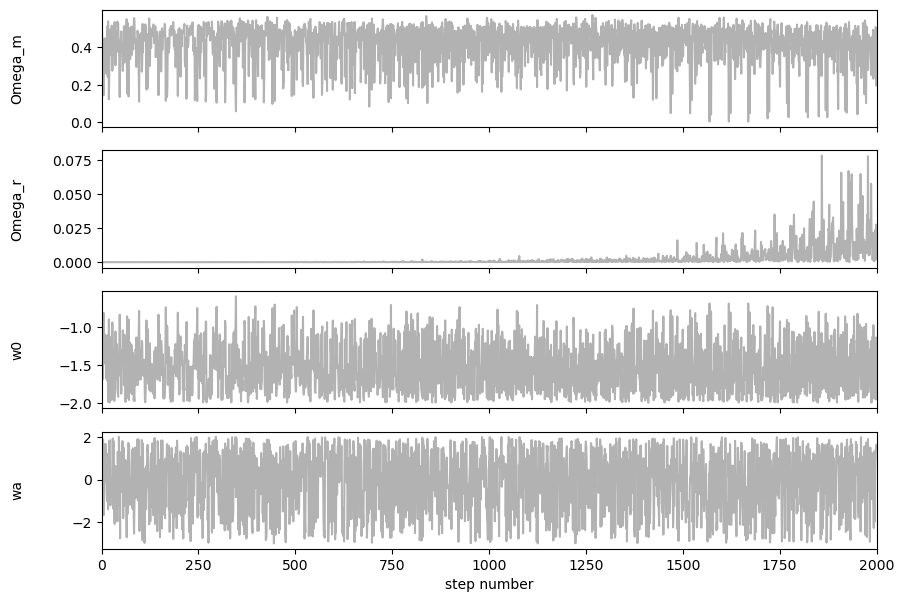

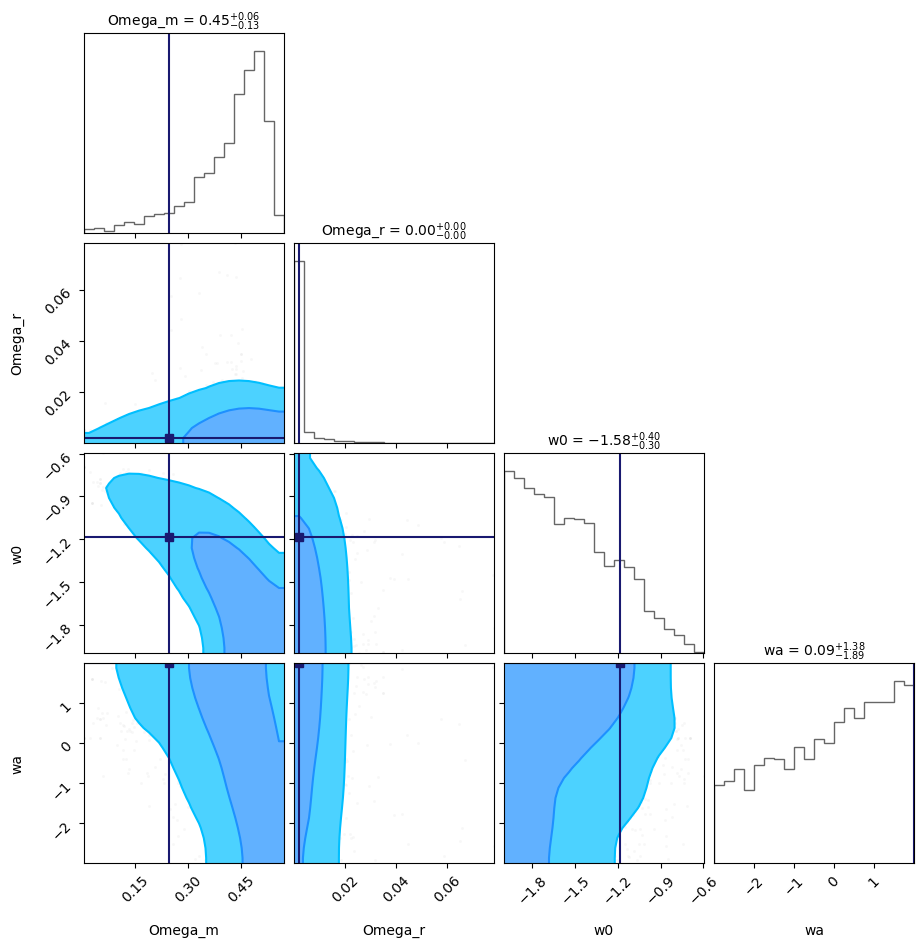

In [251]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])

#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_m", "Omega_r", "w0", "wa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

#'mediumvioletred'
#'hotpink', 'deeppink'

#'midnightblue'
#'deepskyblue', 'dodgerblue'

level_colors = ['deepskyblue', 'dodgerblue']

contourf_kwargs = {
    "colors": ['white', 'deepskyblue', 'dodgerblue'],  # Colors for the filled contours
    "alpha": 0.7  # Transparency of the filled contours
}
fig = corner.corner(reshaped_samples,
                    labels=labels,
                    truths=best_fit_params,
                    truth_color='midnightblue',
                    plot_contours=True,
                    fill_contours=True,
                    levels=[0.68, 0.95],
                    smooth=2.0,
                    show_titles=True,
                    title_fmt=".2f",
                    title_kwargs={"fontsize": 10},
                    hist_kwargs={"density": True, "alpha": 0.6},
                    contour_kwargs={"colors": level_colors},
                    contourf_kwargs=contourf_kwargs
                    )
    
plt.show()

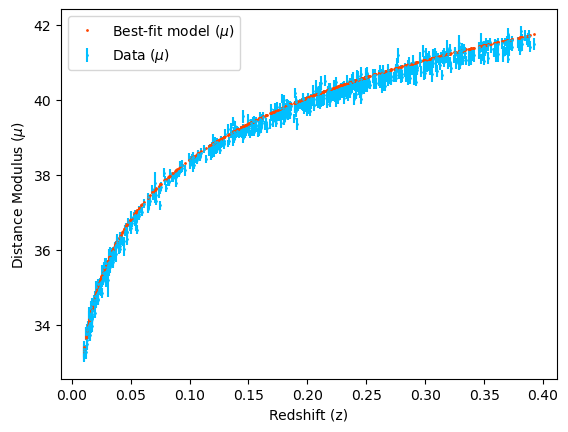

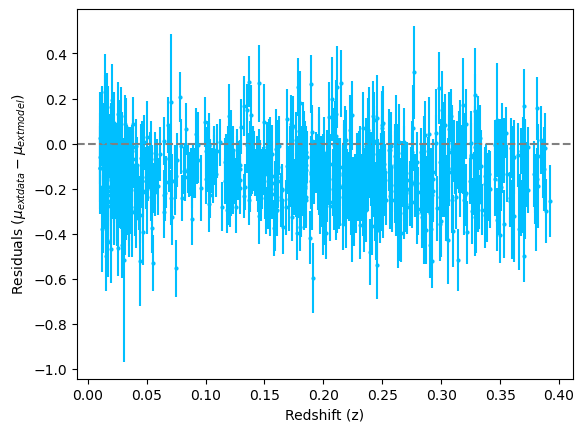

In [252]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
best_fit_params_mcmc_std = np.std(reshaped_samples, axis=0)
mu_model_best_mcmc = get_mu(z_data_low, H0, *best_fit_params_mcmc)

plt.errorbar(z_data_low, mu_data_low, yerr=dmb_low, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data_low, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data_low - mu_model_best_mcmc
plt.errorbar(z_data_low, residuals_mcmc, yerr=dmb_low, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

In [253]:
print("--------------------------------------")
print("Best-fit parameters (MCMC):")
print("Omega_m:", best_fit_params_mcmc[0], "+/-", best_fit_params_mcmc_std[0])
print("Omega_r:", best_fit_params_mcmc[1], "+/-", best_fit_params_mcmc_std[1])
print("w0:", best_fit_params_mcmc[2], "+/-", best_fit_params_mcmc_std[2])
print("wa:", best_fit_params_mcmc[3], "+/-", best_fit_params_mcmc_std[3])
print("--------------------------------------")

--------------------------------------
Best-fit parameters (MCMC):
Omega_m: 0.4185737726535978 +/- 0.10425725657247786
Omega_r: 0.0023465845434146866 +/- 0.006700513692060326
w0: -1.5360688285305808 +/- 0.3164856640653433
wa: -0.1196976649414277 +/- 1.412256771218605
--------------------------------------


### Statistics

In [254]:
samples_Omega_m = reshaped_samples[:, 0]
samples_Omega_r = reshaped_samples[:, 1]
samples_w0 = reshaped_samples[:, 2]
samples_wa = reshaped_samples[:, 3]

samples_dict = {
    "Omega_m": samples_Omega_m,
    "Omega_r": samples_Omega_r,
    "w0": samples_w0,
    "wa": samples_wa
}

for key, value in samples_dict.items():
    print(f"Mean of {key}: {np.mean(value)}")
    print(f"Standard deviation of {key}: {np.std(value)}")
    print(f"Median of {key}: {np.median(value)}")
    print(f"68% credible interval of {key}: {np.percentile(value, [16, 84])}")
    print(f"95% credible interval of {key}: {np.percentile(value, [2.5, 97.5])}")
    print(f"Skewness of {key}: {stats.skew(value)}")
    print(f"Kurtosis of {key}: {stats.kurtosis(value)}")
    print("--------------------------------------")

Mean of Omega_m: 0.4185737726535974
Standard deviation of Omega_m: 0.10425725657247786
Median of Omega_m: 0.449216693244579
68% credible interval of Omega_m: [0.32352454 0.50918257]
95% credible interval of Omega_m: [0.13544411 0.53992368]
Skewness of Omega_m: -1.348315650418795
Kurtosis of Omega_m: 1.6456274499893437
--------------------------------------
Mean of Omega_r: 0.002346584543414685
Standard deviation of Omega_r: 0.006700513692060323
Median of Omega_r: 0.0001875237672163048
68% credible interval of Omega_r: [9.43967343e-06 2.82258952e-03]
95% credible interval of Omega_r: [1.06081328e-06 2.12575551e-02]
Skewness of Omega_r: 5.741767610858311
Kurtosis of Omega_r: 43.41970343827834
--------------------------------------
Mean of w0: -1.536068828530581
Standard deviation of w0: 0.3164856640653431
Median of w0: -1.577682507752634
68% credible interval of w0: [-1.87425107 -1.17546426]
95% credible interval of w0: [-1.98202903 -0.86677381]
Skewness of w0: 0.4879192972317104
Kurtosi

**N.B.:**

* positive skewness: the distribution has a long tail on the right side;
* negative skewness: the distribution has a long tail on the left side;
* kurtosis > 3: the distribution has heavy tails and a sharp peak, indicating a higher likelihood of extreme values;
* kurtosis < 3: the distribution has light tails and a flatter peak, indicating a lower likelihood of extreme values.